## KMeans Clustering of Hyperspectral Vegetation (standardized spectra)

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
fname = "../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../image_files/veg_00108.hdr...
reading ../image_files/veg_00108.raw...


In [3]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [4]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [5]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)

In [6]:
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
import time

distortions = []
elapsed_time = []
K = range(3, 21)

for knum in K:
    start_time = time.time()
    kmeansModel = MiniBatchKMeans(n_clusters = knum, batch_size=20)
    kmeansModel.fit(cube_standard)
    elapsed_time.append(time.time() - start_time)
    distortions.append(np.sum(np.min(cdist(cube_standard, kmeansModel.cluster_centers_, 'euclidean'), axis=1)) / cube_standard.shape[0])
    print(knum, distortions[knum-3], elapsed_time[knum-3])

3 3.531490009839444 74.851309299469
4 3.1062371400601325 70.94362545013428
5 2.810081824432819 76.03131055831909
6 2.785879805494279 71.47176122665405
7 2.4330607389465517 75.42350125312805
8 2.3260218406339654 76.26253414154053
9 2.1743076961004424 116.38357305526733
10 2.52305571094139 75.95963096618652
11 2.1462453965217474 77.05825710296631
12 2.1205186736558046 76.61423945426941
13 1.972681321166124 134.19770288467407
14 2.0181821090589374 121.26089334487915
15 1.9085473910040862 91.84510517120361
16 1.9598377536742548 78.96720170974731
17 1.8537489613803984 219.54764676094055
18 1.8509989688082409 86.00219106674194
19 2.0466428646737853 81.23504042625427
20 1.7989511645247414 158.22995686531067


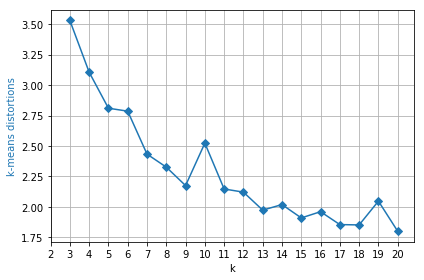

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('k-means distortions', color=color)
ax1.plot(K, distortions, 'D-', color=color)
ax1.tick_params(axis='y', labelcolor='black')

#ax2 = ax1.twinx()

#color = 'tab:orange'
#ax2.set_ylabel('fit time (seconds)', color=color)
#ax2.plot(K, elapsed_time, 'o--', color=color)
#ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
plt.xticks(np.arange(min(K)-1, max(K)+1, 1.0))
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/9_kmeans_elbow_standardized.png")

In [ ]:
cube_wo_median = cube_standard - np.median(cube_standard, axis=1, keepdims=True)

In [33]:
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
import time

distortions = []
elapsed_time = []
K = range(3, 21)

for knum in K:
    start_time = time.time()
    kmeansModel = MiniBatchKMeans(n_clusters = knum, batch_size=20)
    kmeansModel.fit(cube_wo_median)
    elapsed_time.append(time.time() - start_time)
    distortions.append(np.sum(np.min(cdist(cube_wo_median, kmeansModel.cluster_centers_, 'euclidean'), axis=1)) / cube_wo_median.shape[0])
    print(knum, distortions[knum-3], elapsed_time[knum-3])

3 4.661655464968914 67.1736409664154
4 4.176781376393225 66.8376977443695
5 3.7233284837602536 70.37927436828613
6 3.527423129820315 66.81278276443481
7 3.198583957630431 120.64580583572388
8 3.1361189844022723 65.9503104686737
9 2.9317569213284864 67.14882278442383
10 2.9887409481460874 67.0767514705658
11 2.7639261751370667 67.95747900009155
12 2.826114390498045 67.98856472969055


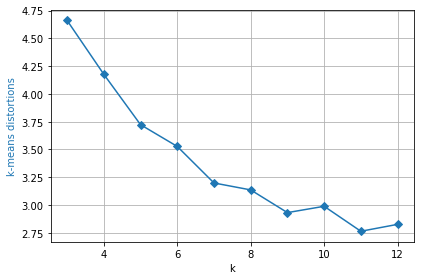

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('k-means distortions', color=color)
ax1.plot(K, distortions, 'D-', color=color)
ax1.tick_params(axis='y', labelcolor='black')

#ax2 = ax1.twinx()

#color = 'tab:orange'
#ax2.set_ylabel('fit time (seconds)', color=color)
#ax2.plot(K, elapsed_time, 'o--', color=color)
#ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
plt.xticks(np.arange(min(K)-1, max(K)+1, 1.0))
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/10_kmeans_elbow_standardized_without_median.png")

(848,) (848, 1600, 1600)


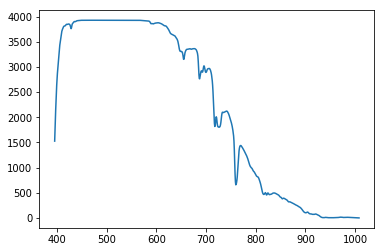

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

avg_sky_spectrum = cube_sub[:, :400].mean((1,2))
min_sky_spectrum = min(avg_sky_spectrum)
avg_sky_spectrum = avg_sky_spectrum - min_sky_spectrum

print(avg_sky_spectrum.shape, cube_sub.shape)
plt.plot(cube.waves, avg_sky_spectrum)

In [9]:
reflectance = np.divide(cube_sub, avg_sky_spectrum[:, None, None], out=np.zeros_like(cube_sub), where=avg_sky_spectrum[:, None, None]!=0)
print(reflectance.shape)
reflectance_reshaped = reflectance.transpose(1,2,0).reshape((reflectance.shape[1]*reflectance.shape[2]), reflectance.shape[0])
print(reflectance_reshaped.shape)

(848, 1600, 1600)
(2560000, 848)


In [11]:
index_cut = (np.abs(cube.waves - 850.0)).argmin()
reflectance_sub = reflectance_reshaped[:, :index_cut]

In [12]:
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
import time

distortions = []
elapsed_time = []
K = range(3, 21)

for knum in K:
    start_time = time.time()
    kmeansModel = MiniBatchKMeans(n_clusters = knum, batch_size=20)
    kmeansModel.fit(reflectance_sub)
    elapsed_time.append(time.time() - start_time)
    distortions.append(np.sum(np.min(cdist(reflectance_sub, kmeansModel.cluster_centers_, 'euclidean'), axis=1)) / reflectance_sub.shape[0])
    print(knum, distortions[knum-3], elapsed_time[knum-3])

3 2.3717836166080346 90.05097603797913
4 1.9516023437491716 86.2913064956665
5 1.6456979001607561 89.09364724159241
6 1.4996425321568805 84.19872999191284
7 1.3314737995206631 77.65355801582336
8 1.2392902534916486 130.61887645721436
9 1.2046475434674038 129.10119938850403
10 1.1259079491950503 78.23819136619568
11 1.0574356519447872 104.09612369537354
12 1.0737834379681044 78.7837541103363


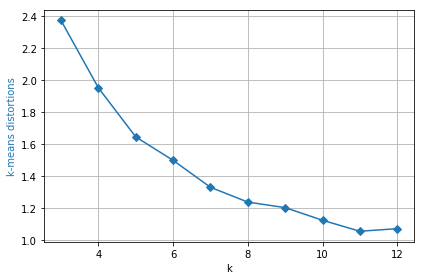

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('k-means distortions', color=color)
ax1.plot(K, distortions, 'D-', color=color)
ax1.tick_params(axis='y', labelcolor='black')

#ax2 = ax1.twinx()

#color = 'tab:orange'
#ax2.set_ylabel('fit time (seconds)', color=color)
#ax2.plot(K, elapsed_time, 'o--', color=color)
#ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
plt.xticks(np.arange(min(K)-1, max(K)+1, 1.0))
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/11_kmeans_elbow_reflectance.png")